In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
# # Enable quiet mode to hide verbose output
# !pip install -q nilearn

# # Install PyTorch + torchvision + torchaudio for Colab GPU
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# # Install PyTorch Geometric with precompiled wheels for Colab
# !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
# !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
# !pip install -q torch-cluster -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
# !pip install -q torch-spline-conv -f https://data.pyg.org/whl/torch-2.8.0+cu126.html
# !pip install -q torch-geometric -f https://data.pyg.org/whl/torch-2.8.0+cu126.html

# # Check installations
# import torch, nilearn
# import torch_geometric
# print("Torch:", torch.__version__)
# print("Nilearn:", nilearn.__version__)
# print("PyG:", torch_geometric.__version__)

In [19]:
# Enable quiet mode to hide verbose output
!pip install -q nilearn

# Ensure a stable PyTorch version
!pip install torch==2.5.1 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# Install compatible PyG wheels for torch 2.5.1 + cu121
!pip install torch-scatter==2.1.2 -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-sparse==0.6.18 -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-cluster==1.6.3 -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-spline-conv==1.2.2 -f https://data.pyg.org/whl/torch-2.5.1+cu121.html
!pip install torch-geometric==2.6.1

# Check installations
import torch, nilearn
import torch_geometric
print("Torch:", torch.__version__)
print("Nilearn:", nilearn.__version__)
print("PyG:", torch_geometric.__version__)

Looking in indexes: https://download.pytorch.org/whl/cu121
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
Torch: 2.5.1+cu121
Nilearn: 0.12.1
PyG: 2.6.1


In [20]:
import pandas as pd
import os

# Paths
data_dir = '/content/drive/Shareddrives/291A_Brain_Connectomes/AABC_Release1_Non-imaging_Data-XL.csv'
cov_dir = '/content/drive/Shareddrives/291A_Brain_Connectomes/FullCorrelationSubjects'

# Load phenotypic data
phen_df = pd.read_csv(data_dir, low_memory=False)
subject_ids = phen_df.iloc[1:, 0].tolist()

# Pre-list files in the folder
existing_files = set(os.listdir(cov_dir))


In [21]:
import os
import pandas as pd
import numpy as np

cov_dict = {}
pheno_dict = {}
count = 0
max_subjects = 500

def load_covariance_numeric(path):
    """
    Load a CSV covariance/correlation matrix and return only the numeric part.
    Assumes first row and first column are labels.
    """
    df = pd.read_csv(path, header=None)
    numeric_matrix = df.iloc[1:, 1:].to_numpy(dtype=float)  # skip first row/column
    return numeric_matrix

for subject_id in subject_ids:
    filename = f"{subject_id}.csv"

    if filename in existing_files:
        # Load numeric covariance matrix
        cov_matrix = load_covariance_numeric(os.path.join(cov_dir, filename))

        # Load phenotypic row
        row = phen_df.loc[phen_df.iloc[:, 0] == subject_id]
        if row.empty:
            continue  # skip if no phenotypic info
        row_dict = row.iloc[0].to_dict()

        # Add to dicts
        cov_dict[subject_id] = cov_matrix
        pheno_dict[subject_id] = row_dict

        count += 1
        if count >= max_subjects:
            break

print("Loaded subjects:", len(cov_dict))
first_id = list(cov_dict.keys())[0]
print("Example subject:", first_id)
print("Covariance shape:", cov_dict[first_id].shape)
print("Phenotype keys:", list(pheno_dict[first_id].keys())[:10])


Loaded subjects: 500
Example subject: HCA6000030_V1
Covariance shape: (379, 379)
Phenotype keys: ['id_event - Subject ID concatenated data collection event (V1, V2, V3, etc.)', 'id - Subject ID', 'event - Study-specific visit/event short name (V1, In-person visit 1 | V2, In-person visit 2 | V3, In-person visit 3 | V4, In-person visit 4 | F1, First followup survey one year after first in-person visit in HCA | F2, Second followup survey in HCA | F3, Third followup survey in HCA | CR, Surveys collected remotely during Covid lock-down without regard to visit timing | AF1, First followup survey one year after first in-person visit in AABC)', 'study - Study during which data for this timepoint were collected', 'yearquarter_V1 - Year and Quarter of initial visit in HCA or AABC (e.g. year and quarter of V1)', 'days_from_V1 - Number of days from initial visit in HCA or AABC (e.g. days passed since V1)', 'yearquarter_event - Year and Quarter of event', 'age_open - Age in years, truncated at 90. 

In [22]:
import torch
from torch_geometric.data import Data
import numpy as np

# MOCA total score column
moca_col = "ravlt_learning_score - Q-Interactive RAVLT: RAVLT ir RAVL2 diff v-i aka Learning Score"

def clean_float(val):
    """Convert weird strings or missing entries into float."""
    try:
        return float(val)
    except:
        return np.nan

dataset = []
threshold = 0.2

for subj_id, cov_matrix in cov_dict.items():

    # Skip if MOCA total is missing
    if moca_col not in pheno_dict[subj_id]:
        continue

    moca_value = clean_float(pheno_dict[subj_id][moca_col])
    if np.isnan(moca_value):
        continue

    # Target = MOCA total score
    y = torch.tensor([moca_value], dtype=torch.float)

    # Convert and symmetrize connectivity matrix
    cov_matrix = np.array(cov_matrix, dtype=float)
    cov_matrix = (cov_matrix + cov_matrix.T) / 2

    # Threshold weak edges
    cov_matrix[np.abs(cov_matrix) < threshold] = 0

    # Node features = each node receives its whole row of the matrix
    x = torch.tensor(cov_matrix, dtype=torch.float)

    # Graph edges
    row, col = np.nonzero(cov_matrix)
    edge_index = torch.tensor(np.vstack((row, col)), dtype=torch.long)

    # Edge weights
    edge_attr = torch.tensor(cov_matrix[row, col], dtype=torch.float).unsqueeze(1)

    # Create PyG graph
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_attr=edge_attr,
        y=y,
        sub_id=subj_id
    )

    dataset.append(data)

print(f"Prepared {len(dataset)} subjects for PyG GNN.")


Prepared 491 subjects for PyG GNN.


In [23]:
import torch
from torch_geometric.loader import DataLoader
import torch.nn.functional as F
from torch import nn, optim
from torch_geometric.nn import GATConv, global_mean_pool
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Model definition
class GATRegressor(nn.Module):
    def __init__(self, in_dim, hidden_dim=8, heads=2):
        super().__init__()
        self.gat1 = GATConv(in_dim, hidden_dim, heads=heads, concat=True, dropout=0.4, add_self_loops=False)
        self.gat2 = GATConv(hidden_dim * heads, hidden_dim, heads=heads, concat=True, dropout=0.4, add_self_loops=False)
        self.gat3 = GATConv(hidden_dim * heads, 1, heads=1, concat=False, dropout=0.4, add_self_loops=False)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.elu(self.gat1(x, edge_index))
        x = F.elu(self.gat2(x, edge_index))
        x = self.gat3(x, edge_index)
        return global_mean_pool(x, batch).view(-1)

# Scale ages
ages_raw = torch.tensor([d.y.item() for d in dataset], dtype=torch.float).view(-1, 1)
scaler = StandardScaler()
ages_scaled = torch.tensor(scaler.fit_transform(ages_raw), dtype=torch.float)

for i, d in enumerate(dataset):
    d.y = ages_scaled[i]  # replace y with scaled value

# Split dataset
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# Model, optimizer, loss
in_dim = dataset[0].x.shape[1]
model = GATRegressor(in_dim)
optimizer = optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

In [24]:
# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        pred = model(batch)
        loss = criterion(pred, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1:03d} - Train Loss: {total_loss/len(train_loader):.4f}")

Epoch 001 - Train Loss: 1.0108
Epoch 002 - Train Loss: 0.9018
Epoch 003 - Train Loss: 0.8777
Epoch 004 - Train Loss: 0.7860
Epoch 005 - Train Loss: 0.7386
Epoch 006 - Train Loss: 0.6740
Epoch 007 - Train Loss: 0.6721
Epoch 008 - Train Loss: 0.5377
Epoch 009 - Train Loss: 0.5178
Epoch 010 - Train Loss: 0.4307
Epoch 011 - Train Loss: 0.4442
Epoch 012 - Train Loss: 0.4036
Epoch 013 - Train Loss: 0.3334
Epoch 014 - Train Loss: 0.3162
Epoch 015 - Train Loss: 0.2503
Epoch 016 - Train Loss: 0.2205
Epoch 017 - Train Loss: 0.2266
Epoch 018 - Train Loss: 0.1925
Epoch 019 - Train Loss: 0.1554
Epoch 020 - Train Loss: 0.1217
Epoch 021 - Train Loss: 0.1019
Epoch 022 - Train Loss: 0.1067
Epoch 023 - Train Loss: 0.1018
Epoch 024 - Train Loss: 0.0852
Epoch 025 - Train Loss: 0.0694
Epoch 026 - Train Loss: 0.0569
Epoch 027 - Train Loss: 0.0476
Epoch 028 - Train Loss: 0.0532
Epoch 029 - Train Loss: 0.0403
Epoch 030 - Train Loss: 0.0682
Epoch 031 - Train Loss: 0.0608
Epoch 032 - Train Loss: 0.0608
Epoch 03

In [25]:
# Evaluation
model.eval()
preds = []

with torch.no_grad():
    for batch in test_loader:
        pred_scaled = model(batch)
        # convert back to real age
        pred_np = pred_scaled.numpy().reshape(-1, 1)
        pred_real = scaler.inverse_transform(pred_np).flatten()
        actual_np = batch.y.numpy().reshape(-1, 1)
        actual_real = scaler.inverse_transform(actual_np).flatten()

        for sub_id, p_val, a_val in zip(batch.sub_id, pred_real, actual_real):
            preds.append((sub_id, float(p_val), float(a_val)))
            print(f"{sub_id}: predicted {p_val:.2f} RAVLT, actual {a_val:.2f} RAVLT")

# Metrics
pred_vals = np.array([p for _, p, _ in preds])
actual_vals = np.array([a for _, _, a in preds])
rmse = np.sqrt(np.mean((pred_vals - actual_vals) ** 2))
mae = np.mean(np.abs(pred_vals - actual_vals))

print(f"\nRoot Mean Squared Error: {rmse:.2f} RAVLT")
print(f"Mean Absolute Error: {mae:.2f} RAVLT")

HCA6766896_V3: predicted 7.29 RAVLT, actual 5.00 RAVLT
HCA6125050_V1: predicted 3.59 RAVLT, actual 2.00 RAVLT
HCA6752481_V1: predicted 3.95 RAVLT, actual 7.00 RAVLT
HCA6793596_V2: predicted 4.99 RAVLT, actual 7.00 RAVLT
HCA6742377_V1: predicted 6.63 RAVLT, actual 9.00 RAVLT
HCA6579089_V2: predicted 5.60 RAVLT, actual 7.00 RAVLT
HCA6053758_V1: predicted 6.03 RAVLT, actual 6.00 RAVLT
HCA6436774_V1: predicted 7.90 RAVLT, actual 5.00 RAVLT
HCA6826989_V1: predicted 7.12 RAVLT, actual 8.00 RAVLT
HCA6451063_V1: predicted 6.29 RAVLT, actual 10.00 RAVLT
HCA6010538_V1: predicted 6.74 RAVLT, actual 3.00 RAVLT
HCA6249977_V1: predicted 4.88 RAVLT, actual 8.00 RAVLT
HCA6732374_V2: predicted 4.61 RAVLT, actual 5.00 RAVLT
HCA6399087_V3: predicted 7.31 RAVLT, actual 10.00 RAVLT
HCA6640672_V1: predicted 2.81 RAVLT, actual 5.00 RAVLT
HCA6108050_V1: predicted 4.17 RAVLT, actual 4.00 RAVLT
HCA6749088_V1: predicted 4.36 RAVLT, actual 9.00 RAVLT
HCA6749088_V2: predicted 6.93 RAVLT, actual 5.00 RAVLT
HCA66465

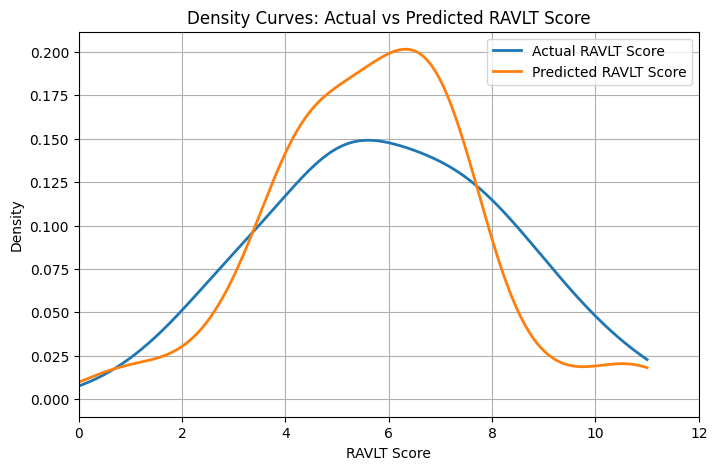

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Data
actual = np.array([a for _, _, a in preds])
pred = np.array([p for _, p, _ in preds])

# Compute KDE
kde_actual = gaussian_kde(actual)
kde_pred = gaussian_kde(pred)

# Evaluate over a common grid
xmin = min(actual.min(), pred.min())
xmax = max(actual.max(), pred.max())
xgrid = np.linspace(xmin, xmax, 500)

plt.figure(figsize=(8,5))
plt.plot(xgrid, kde_actual(xgrid), label="Actual RAVLT Score", linewidth=2)
plt.plot(xgrid, kde_pred(xgrid), label="Predicted RAVLT Score", linewidth=2)

plt.xlabel("RAVLT Score")
plt.ylabel("Density")
plt.xlim(0, 12)
plt.title("Density Curves: Actual vs Predicted RAVLT Score")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
# Attention Extraction
import numpy as np
import matplotlib.pyplot as plt

model.eval()

all_attn_matrices = {}      # key: subj_id, value: NxN attention matrix
num_rois = dataset[0].x.shape[0]

print("\nExtracting attention matrices...")

with torch.no_grad():
    for batch in test_loader:

        # Get attention weights from the first GAT layer
        _, (edge_index, attn_weights) = model.gat1(
            batch.x, batch.edge_index, return_attention_weights=True
        )

        # Average across attention heads
        attn_mean = attn_weights.mean(dim=1).cpu().numpy()

        # Boundaries for each graph in the batch
        batch_graph_ptr = batch.ptr.cpu().numpy()
        edge_index_np = edge_index.cpu().numpy()

        # Loop through subjects in this batch
        for i, subj_id in enumerate(batch.sub_id):

            start = batch_graph_ptr[i]
            end   = batch_graph_ptr[i+1]

            # Extract edges belonging to this subject
            node_mask = (edge_index_np[0] >= start) & (edge_index_np[0] < end)
            idxs = np.where(node_mask)[0]

            # Build empty N×N matrix
            attn_mat = np.zeros((num_rois, num_rois))

            # Fill matrix
            for j in idxs:
                u = edge_index_np[0, j] - start
                v = edge_index_np[1, j] - start
                attn_mat[u, v] = attn_mean[j]
                attn_mat[v, u] = attn_mean[j]

            # Store directly into dict
            all_attn_matrices[subj_id] = attn_mat

print(f"Collected attention matrices for {len(all_attn_matrices)} subjects.")



Extracting attention matrices...
Collected attention matrices for 99 subjects.


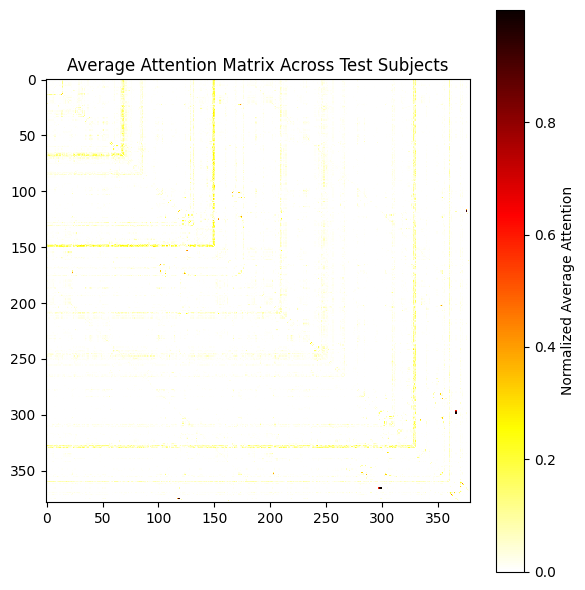

In [28]:
# Average Attention Matrix
attn_stack = np.stack(list(all_attn_matrices.values()), axis=0)

avg_attn = np.mean(attn_stack, axis=0)

plt.figure(figsize=(6, 6))
plt.imshow(avg_attn / (avg_attn.max() + 1e-8), cmap='hot_r', interpolation='nearest')
plt.colorbar(label="Normalized Average Attention")
plt.title("Average Attention Matrix Across Test Subjects")
plt.tight_layout()
plt.show()

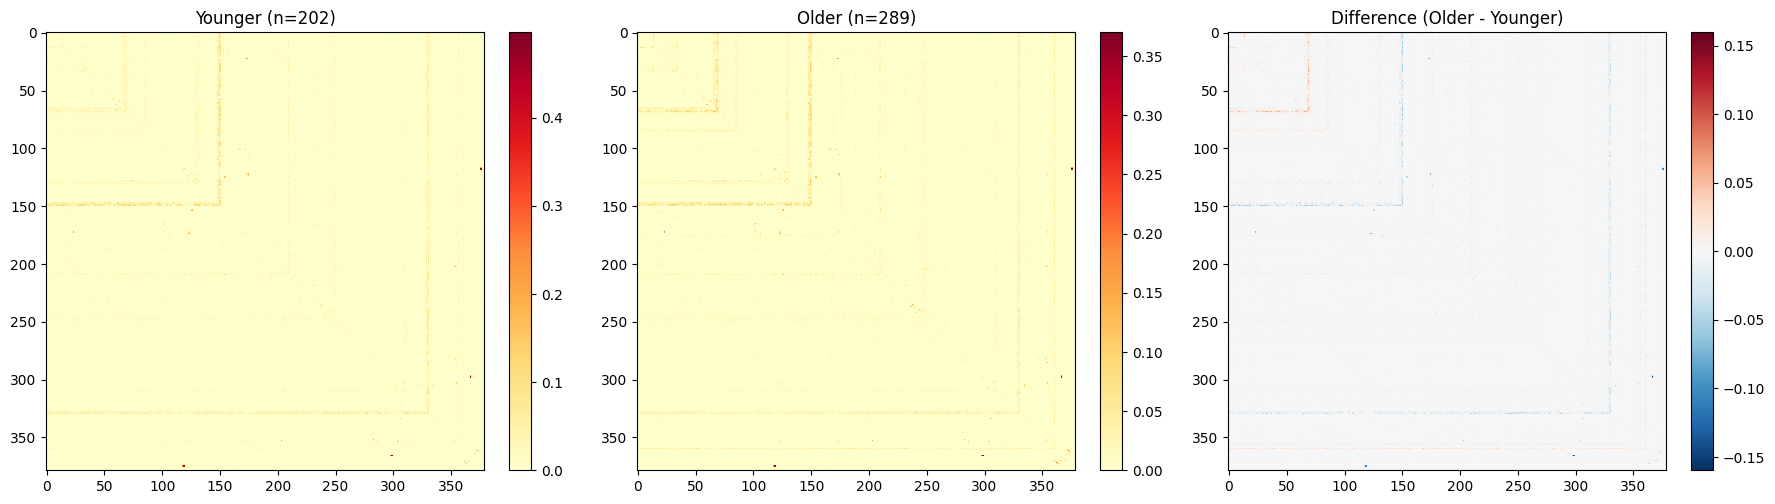

In [29]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.loader import DataLoader

# Attention extraction
def extract_attention_matrices_dict(model, dataset, layer='gat1', batch_size=4, ignore_self_loops=True):
    """
    Extract attention matrices for all subjects in dataset, return as dict keyed by sub_id.

    Args:
        model: Trained GAT model
        dataset: list of PyG Data objects
        layer: which GAT layer to extract attention from
        batch_size: batch size for DataLoader
        ignore_self_loops: if True, set diagonal to 0

    Returns:
        all_attn_matrices: dict {sub_id: NxN attention matrix}
    """
    model.eval()
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    all_attn_matrices = {}
    num_nodes = dataset[0].x.shape[0]

    with torch.no_grad():
        for batch in loader:
            gat_layer = getattr(model, layer)
            _, (edge_index, attn_weights) = gat_layer(
                batch.x, batch.edge_index, return_attention_weights=True
            )

            # Average over heads if multi-head
            if attn_weights.dim() > 1 and attn_weights.shape[1] > 1:
                attn_weights = attn_weights.mean(dim=1)

            edge_index_np = edge_index.cpu().numpy()
            attn_np = attn_weights.cpu().numpy()
            batch_ptr = batch.ptr.cpu().numpy()

            for i, sub_id in enumerate(batch.sub_id):
                start, end = batch_ptr[i], batch_ptr[i + 1]
                mask = (edge_index_np[0] >= start) & (edge_index_np[0] < end)
                idxs = np.where(mask)[0]

                attn_mat = np.zeros((num_nodes, num_nodes))
                for j in idxs:
                    u = edge_index_np[0, j] - start
                    v = edge_index_np[1, j] - start
                    attn_mat[u, v] = attn_np[j]
                    attn_mat[v, u] = attn_np[j]  # symmetric

                if ignore_self_loops:
                    np.fill_diagonal(attn_mat, 0)

                all_attn_matrices[sub_id] = attn_mat

    return all_attn_matrices

# Compare attention by age
def compare_attention_by_age_dict(dataset, all_attn_matrices, age_threshold=None):
    """
    Compare attention patterns between younger and older subjects.
    all_attn_matrices: dict {sub_id: NxN attention matrix}
    """
    ages = {d.sub_id: d.y.item() for d in dataset}
    if age_threshold is None:
        age_threshold = np.median(list(ages.values()))

    younger_subs = [sub_id for sub_id, age in ages.items() if age < age_threshold]
    older_subs = [sub_id for sub_id, age in ages.items() if age >= age_threshold]

    if len(younger_subs) == 0 or len(older_subs) == 0:
        raise ValueError("No subjects in one of the age groups.")

    younger_attn = np.mean([all_attn_matrices[sub_id] for sub_id in younger_subs], axis=0)
    older_attn = np.mean([all_attn_matrices[sub_id] for sub_id in older_subs], axis=0)
    diff_attn = older_attn - younger_attn

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    im1 = axes[0].imshow(younger_attn, cmap='YlOrRd', interpolation='nearest')
    axes[0].set_title(f'Younger (n={len(younger_subs)})')
    plt.colorbar(im1, ax=axes[0], fraction=0.046)

    im2 = axes[1].imshow(older_attn, cmap='YlOrRd', interpolation='nearest')
    axes[1].set_title(f'Older (n={len(older_subs)})')
    plt.colorbar(im2, ax=axes[1], fraction=0.046)

    im3 = axes[2].imshow(diff_attn, cmap='RdBu_r', interpolation='nearest',
                         vmin=-np.abs(diff_attn).max(),
                         vmax=np.abs(diff_attn).max())
    axes[2].set_title('Difference (Older - Younger)')
    plt.colorbar(im3, ax=axes[2], fraction=0.046)

    plt.tight_layout()
    return fig, (younger_attn, older_attn, diff_attn)

all_attn_matrices = extract_attention_matrices_dict(model, dataset, layer='gat1')
fig, (young_attn, old_attn, diff_attn) = compare_attention_by_age_dict(dataset, all_attn_matrices)
plt.show()


### Spectral Analysis

In [33]:
import numpy as np
from scipy.spatial.distance import cosine
from sklearn.cluster import KMeans
from scipy.linalg import eigh
import networkx as nx

# Laplacian
def laplacian_from_adj(A):
    A = np.array(A, dtype=float)
    np.fill_diagonal(A, 0)
    A = np.clip(A, a_min=0, a_max=None)
    D = np.diag(A.sum(axis=1))
    return D - A

# Spectral subnetworks
def spectral_subnetworks_from_L(L, p=6, k_clusters=6, normalize_eigvecs=True):
    vals, vecs = eigh(L)
    Vp = vecs[:, :p]
    if normalize_eigvecs:
        Vp = Vp / (np.linalg.norm(Vp, axis=1, keepdims=True) + 1e-12)
    kmeans = KMeans(n_clusters=k_clusters, random_state=0).fit(Vp)
    labels = kmeans.labels_
    return labels, vals[:p], Vp

# Extract high-attention edges
def extract_high_attention_edges(attn_mat, percentile=80):
    """
    Extract top X percentile of edges by attention weight.
    Returns edge list as set of (i,j) tuples where i < j

    Args:
        attn_mat: NxN attention matrix
        percentile: Keep edges above this percentile (0-100)
                   e.g., 80 = top 20% of edges
    """
    N = attn_mat.shape[0]
    mat = attn_mat.copy()
    np.fill_diagonal(mat, 0)

    # Get all non-zero attention values
    all_weights = []
    for i in range(N):
        for j in range(i+1, N):
            weight = max(mat[i, j], mat[j, i])  # Take max of both directions
            if weight > 0:
                all_weights.append(weight)

    if len(all_weights) == 0:
        return set()

    # Compute threshold based on percentile
    threshold = np.percentile(all_weights, percentile)

    # Extract edges above threshold
    high_attn_edges = set()
    for i in range(N):
        for j in range(i+1, N):
            weight = max(mat[i, j], mat[j, i])
            if weight >= threshold:
                high_attn_edges.add((i, j))

    return high_attn_edges

# Extract spectral cluster edges
def extract_spectral_edges(spec_labels):
    """
    Extract edges within each spectral cluster.
    Returns dict mapping cluster_id -> set of edges
    """
    N = len(spec_labels)
    spectral_edges = {}

    for cluster_id in np.unique(spec_labels):
        cluster_nodes = np.where(spec_labels == cluster_id)[0]
        edges_in_cluster = set()

        # All edges within this cluster
        for i in cluster_nodes:
            for j in cluster_nodes:
                if i < j:  # Avoid duplicates
                    edges_in_cluster.add((i, j))

        spectral_edges[cluster_id] = edges_in_cluster

    return spectral_edges

# Find consensus subnetworks
def find_consensus_subnetworks(high_attn_edges, spectral_edges, spec_labels):
    """
    Find edges that appear in BOTH high-attention and spectral clusters.

    Returns:
        consensus_subnetworks: dict with cluster_id -> consensus info
    """
    consensus_subnetworks = {}

    for cluster_id, cluster_edges in spectral_edges.items():
        # Find intersection: edges in both sets
        consensus_edges = high_attn_edges.intersection(cluster_edges)

        # Calculate overlap metrics
        n_consensus = len(consensus_edges)
        n_cluster = len(cluster_edges)

        if n_cluster > 0:
            overlap_ratio = n_consensus / n_cluster
        else:
            overlap_ratio = 0

        # Get nodes in this cluster
        cluster_nodes = np.where(spec_labels == cluster_id)[0]

        # Get nodes involved in consensus edges
        consensus_nodes = set()
        for i, j in consensus_edges:
            consensus_nodes.add(i)
            consensus_nodes.add(j)

        consensus_subnetworks[cluster_id] = {
            'consensus_edges': consensus_edges,
            'n_consensus_edges': n_consensus,
            'n_cluster_edges': n_cluster,
            'overlap_ratio': overlap_ratio,
            'cluster_nodes': cluster_nodes.tolist(),
            'consensus_nodes': list(consensus_nodes),
            'n_consensus_nodes': len(consensus_nodes)
        }

    return consensus_subnetworks

# Metrics for consensus analysis
def compute_consensus_metrics(consensus_subnetworks, high_attn_edges):
    """
    Compute aggregate metrics across all consensus subnetworks
    """
    # Total consensus edges across all clusters
    total_consensus_edges = set()
    for data in consensus_subnetworks.values():
        total_consensus_edges.update(data['consensus_edges'])

    # What fraction of high-attention edges are in consensus?
    consensus_coverage = len(total_consensus_edges) / len(high_attn_edges) if len(high_attn_edges) > 0 else 0

    # How many clusters have meaningful consensus?
    significant_clusters = sum(1 for data in consensus_subnetworks.values()
                              if data['overlap_ratio'] > 0.1)  # >10% overlap

    return {
        'total_consensus_edges': len(total_consensus_edges),
        'total_high_attn_edges': len(high_attn_edges),
        'consensus_coverage': consensus_coverage,
        'n_significant_clusters': significant_clusters,
        'n_total_clusters': len(consensus_subnetworks)
    }

# Full analysis for all subjects
def analyze_consensus_all_subjects(cov_dict, all_attn_matrices,
                                   percentile=80, p=6, k_clusters=6):
    """
    Perform consensus analysis for all subjects

    Args:
        percentile: Keep top X% of edges by attention (e.g., 80 = top 20%)
        p: Number of eigenvectors for spectral clustering
        k_clusters: Number of clusters
    """
    results = {}

    for subj_id, cov in cov_dict.items():
        if subj_id not in all_attn_matrices:
            continue

        attn = all_attn_matrices[subj_id]
        L = laplacian_from_adj(cov)

        # Spectral clustering
        spec_labels, vals, vecs = spectral_subnetworks_from_L(L, p=p, k_clusters=k_clusters)

        # Extract high-attention edges (PERCENTILE-BASED)
        high_attn_edges = extract_high_attention_edges(attn, percentile=percentile)

        # Extract spectral cluster edges
        spectral_edges = extract_spectral_edges(spec_labels)

        # Find consensus
        consensus_subnetworks = find_consensus_subnetworks(
            high_attn_edges, spectral_edges, spec_labels
        )

        # Compute metrics
        metrics = compute_consensus_metrics(consensus_subnetworks, high_attn_edges)

        results[subj_id] = {
            'consensus_subnetworks': consensus_subnetworks,
            'metrics': metrics,
            'spec_labels': spec_labels,
            'high_attn_edges': high_attn_edges
        }

    return results

# CROSS-SUBJECT CONSENSUS ANALYSIS
def aggregate_consensus_across_subjects(consensus_results, min_subjects=0.5):
    """
    Find consensus edges that appear consistently across multiple subjects.
    """
    n_subjects = len(consensus_results)

    if min_subjects <= 1.0:
        min_count = int(min_subjects * n_subjects)
    else:
        min_count = int(min_subjects)

    # Count how many subjects have each consensus edge
    edge_counts = {}

    for subj_id, result in consensus_results.items():
        # Get all consensus edges for this subject
        all_consensus_edges = set()
        for cluster_data in result['consensus_subnetworks'].values():
            all_consensus_edges.update(cluster_data['consensus_edges'])

        # Count each edge
        for edge in all_consensus_edges:
            if edge not in edge_counts:
                edge_counts[edge] = []
            edge_counts[edge].append(subj_id)

    # Filter edges that appear in enough subjects
    reproducible_edges = {}
    for edge, subjects in edge_counts.items():
        count = len(subjects)
        if count >= min_count:
            reproducible_edges[edge] = {
                'count': count,
                'frequency': count / n_subjects,
                'subjects': subjects
            }

    return reproducible_edges, edge_counts

def find_reproducible_subnetworks(reproducible_edges, min_edge_frequency=0.3, min_cluster_size=5):
    """
    Identify cohesive subnetworks formed by reproducible consensus edges.
    """
    # Build graph from reproducible edges
    G = nx.Graph()
    for edge, data in reproducible_edges.items():
        if data['frequency'] >= min_edge_frequency:
            G.add_edge(edge[0], edge[1], weight=data['frequency'])

    # Find connected components (cohesive subnetworks)
    subnetworks = []
    for component in nx.connected_components(G):
        if len(component) >= min_cluster_size:
            nodes = list(component)
            edges = [(u, v) for u, v in G.edges() if u in component and v in component]

            # Calculate average edge frequency
            avg_frequency = np.mean([reproducible_edges[(min(u,v), max(u,v))]['frequency']
                                    for u, v in edges])

            subnetworks.append({
                'nodes': sorted(nodes),
                'n_nodes': len(nodes),
                'edges': edges,
                'n_edges': len(edges),
                'avg_edge_frequency': avg_frequency,
                'density': len(edges) / (len(nodes) * (len(nodes) - 1) / 2) if len(nodes) > 1 else 0
            })

    # Sort by number of nodes (largest first)
    subnetworks.sort(key=lambda x: x['n_nodes'], reverse=True)

    return subnetworks

def summarize_cluster_consistency(consensus_results):
    """
    Analyze which spectral clusters consistently have high consensus across subjects.
    """
    # Track cluster metrics across all subjects
    cluster_stats = {}

    for subj_id, result in consensus_results.items():
        for cluster_id, data in result['consensus_subnetworks'].items():
            if cluster_id not in cluster_stats:
                cluster_stats[cluster_id] = {
                    'overlap_ratios': [],
                    'n_consensus_edges': [],
                    'n_nodes': [],
                    'subjects_with_cluster': []
                }

            cluster_stats[cluster_id]['overlap_ratios'].append(data['overlap_ratio'])
            cluster_stats[cluster_id]['n_consensus_edges'].append(data['n_consensus_edges'])
            cluster_stats[cluster_id]['n_nodes'].append(len(data['cluster_nodes']))
            cluster_stats[cluster_id]['subjects_with_cluster'].append(subj_id)

    # Compute summary statistics
    summary = []
    for cluster_id, stats in cluster_stats.items():
        summary.append({
            'cluster_id': cluster_id,
            'n_subjects': len(stats['subjects_with_cluster']),
            'mean_overlap': np.mean(stats['overlap_ratios']),
            'std_overlap': np.std(stats['overlap_ratios']),
            'mean_consensus_edges': np.mean(stats['n_consensus_edges']),
            'mean_nodes': np.mean(stats['n_nodes']),
            'high_overlap_subjects': sum(1 for x in stats['overlap_ratios'] if x > 0.1)
        })

    # Sort by mean overlap (best performing clusters first)
    summary.sort(key=lambda x: x['mean_overlap'], reverse=True)

    return summary


# BRAIN REGION MAPPING FUNCTIONS
def map_subnetworks_to_regions(subnetworks, roi_labels):
    """
    Map node IDs in subnetworks to actual brain region names.

    Args:
        subnetworks: List of subnetwork dictionaries
        roi_labels: List of ROI names (e.g., ['R_V1_ROI', 'R_MST_ROI', ...])

    Returns:
        Subnetworks with added 'region_names' field
    """
    for subnet in subnetworks:
        region_names = [roi_labels[node_id] for node_id in subnet['nodes']]
        subnet['region_names'] = region_names

    return subnetworks

def print_subnetwork_regions(subnetworks, roi_labels, n_subnetworks=3):
    """
    Pretty print brain regions in each subnetwork.
    """
    print("BRAIN REGIONS IN REPRODUCIBLE SUBNETWORKS")

    for idx, subnet in enumerate(subnetworks[:n_subnetworks], 1):
        print(f"\n--- Subnetwork {idx} ({subnet['n_nodes']} regions) ---")

        region_names = [roi_labels[node_id] for node_id in subnet['nodes']]

        # Group by hemisphere if ROI names start with L_ or R_
        left_regions = [r for r in region_names if r.startswith('L_')]
        right_regions = [r for r in region_names if r.startswith('R_')]
        other_regions = [r for r in region_names if not (r.startswith('L_') or r.startswith('R_'))]

        if right_regions:
            print(f"\nRight hemisphere ({len(right_regions)} regions):")
            for r in sorted(right_regions):
                print(f"  {r}")

        if left_regions:
            print(f"\nLeft hemisphere ({len(left_regions)} regions):")
            for r in sorted(left_regions):
                print(f"  {r}")

        if other_regions:
            print(f"\nOther regions ({len(other_regions)}):")
            for r in sorted(other_regions):
                print(f"  {r}")

def analyze_subnetwork_composition(subnetworks, roi_labels):
    """
    Analyze what types of brain regions appear in subnetworks.
    """
    print("SUBNETWORK COMPOSITION ANALYSIS")

    for idx, subnet in enumerate(subnetworks[:3], 1):
        region_names = [roi_labels[node_id] for node_id in subnet['nodes']]

        # Count region types (based on common prefixes in HCP parcellation)
        region_types = {}
        for region in region_names:
            # Extract region type (e.g., V1, MST, FEF from R_V1_ROI)
            parts = region.split('_')
            if len(parts) >= 2:
                region_type = parts[1]  # e.g., 'V1', 'MST', '4'
                region_types[region_type] = region_types.get(region_type, 0) + 1

        print(f"\nSubnetwork {idx}:")
        print(f"  Total regions: {len(region_names)}")
        print(f"  Unique region types: {len(region_types)}")
        print(f"  Most common types:")

        # Sort by frequency
        sorted_types = sorted(region_types.items(), key=lambda x: x[1], reverse=True)
        for region_type, count in sorted_types[:10]:
            print(f"    {region_type}: {count}")

# MAIN ANALYSIS PIPELINE

# k=10
fixed_k = 10  # Choose number of clusters
print(f"\nUsing k={fixed_k} clusters\n")

k_values = [fixed_k]
multi_scale_results = {}

for k in k_values:
    results = analyze_consensus_all_subjects(
        cov_dict,
        all_attn_matrices,
        percentile=80,
        p=min(15, k),
        k_clusters=k
    )

    coverage_scores = [r['metrics']['consensus_coverage'] for r in results.values()]
    sig_clusters = [r['metrics']['n_significant_clusters'] for r in results.values()]
    consensus_edges = [r['metrics']['total_consensus_edges'] for r in results.values()]

    multi_scale_results[k] = {
        'results': results,
        'mean_coverage': np.mean(coverage_scores),
        'std_coverage': np.std(coverage_scores),
        'mean_sig_clusters': np.mean(sig_clusters),
        'mean_consensus_edges': np.mean(consensus_edges)
    }

    print(f"  Coverage: {np.mean(coverage_scores):.3f} ± {np.std(coverage_scores):.3f}")
    print(f"  Significant clusters: {np.mean(sig_clusters):.1f}")
    print(f"  Consensus edges: {np.mean(consensus_edges):.1f}")

best_k = fixed_k
consensus_results = multi_scale_results[best_k]['results']

best_k = fixed_k
consensus_results = multi_scale_results[best_k]['results']

# Cross-subject reproducibility
print("CROSS-SUBJECT REPRODUCIBILITY")

reproducible_edges, all_edge_counts = aggregate_consensus_across_subjects(
    consensus_results,
    min_subjects=0.3
)

print(f"\nTotal unique consensus edges: {len(all_edge_counts)}")
print(f"Reproducible edges (≥30% subjects): {len(reproducible_edges)}")

# Show most reproducible edges
print("TOP 50 MOST REPRODUCIBLE CONSENSUS EDGES")
print(f"\n{'Rank':<6} {'Edge (i,j)':<20} {'Frequency':<12} {'# Subjects':<12}")

sorted_edges = sorted(reproducible_edges.items(),
                     key=lambda x: x[1]['frequency'],
                     reverse=True)

for rank, (edge, data) in enumerate(sorted_edges[:50], 1):
    print(f"{rank:<6} {str(edge):<20} {data['frequency']:<12.3f} {data['count']:<12}")

#  Find subnetworks
print("REPRODUCIBLE SUBNETWORKS")

subnetworks = find_reproducible_subnetworks(
    reproducible_edges,
    min_edge_frequency=0.3,
    min_cluster_size=5
)

print(f"\nFound {len(subnetworks)} reproducible subnetworks\n")

for idx, subnet in enumerate(subnetworks[:5]):
    print(f"Subnetwork {idx+1}:")
    print(f"  Nodes: {subnet['n_nodes']} nodes")
    print(f"  Edges: {subnet['n_edges']} edges")
    print(f"  Avg edge frequency: {subnet['avg_edge_frequency']:.3f}")
    print(f"  Density: {subnet['density']:.3f}")
    print(f"  Node IDs: {subnet['nodes'][:15]}{'...' if len(subnet['nodes']) > 15 else ''}")
    print()

# Show edges in each subnetwork
print("EDGES IN EACH REPRODUCIBLE SUBNETWORK")

for idx, subnet in enumerate(subnetworks[:3], 1):
    print(f"\nSubnetwork {idx} ({subnet['n_nodes']} nodes, {subnet['n_edges']} edges)")

    # Get edges with frequencies
    subnet_edges_with_freq = []
    for edge in subnet['edges']:
        edge_tuple = (min(edge[0], edge[1]), max(edge[0], edge[1]))
        if edge_tuple in reproducible_edges:
            freq = reproducible_edges[edge_tuple]['frequency']
            subnet_edges_with_freq.append((edge_tuple, freq))

    # Sort by frequency
    subnet_edges_with_freq.sort(key=lambda x: x[1], reverse=True)

    # Show top 20 or all
    n_show = min(20, len(subnet_edges_with_freq))
    print(f"\nTop {n_show} edges by frequency:")
    print(f"{'Edge':<20} {'Frequency':<12}")

    for edge, freq in subnet_edges_with_freq[:n_show]:
        print(f"{str(edge):<20} {freq:<12.3f}")

    if len(subnet_edges_with_freq) > n_show:
        print(f" and {len(subnet_edges_with_freq) - n_show} more edges")

# Cluster consistency
print("SPECTRAL CLUSTER CONSISTENCY")

cluster_summary = summarize_cluster_consistency(consensus_results)

print(f"\n{'Cluster':<10} {'N Subj':<10} {'Mean Overlap':<15} {'High Overlap':<15} {'Mean Edges':<12}")

for stats in cluster_summary[:15]:
    print(f"{stats['cluster_id']:<10} {stats['n_subjects']:<10} "
          f"{stats['mean_overlap']:<15.3f} {stats['high_overlap_subjects']:<15} "
          f"{stats['mean_consensus_edges']:<12.1f}")



Using k=10 clusters

  Coverage: 0.435 ± 0.106
  Significant clusters: 2.2
  Consensus edges: 1126.6
CROSS-SUBJECT REPRODUCIBILITY

Total unique consensus edges: 43095
Reproducible edges (≥30% subjects): 351
TOP 50 MOST REPRODUCIBLE CONSENSUS EDGES

Rank   Edge (i,j)           Frequency    # Subjects  
1      (34, 149)            0.699        343         
2      (32, 149)            0.682        335         
3      (131, 149)           0.680        334         
4      (29, 149)            0.674        331         
5      (68, 149)            0.646        317         
6      (71, 149)            0.633        311         
7      (69, 149)            0.631        310         
8      (67, 149)            0.629        309         
9      (129, 149)           0.582        286         
10     (np.int64(33), np.int64(34)) 0.572        281         
11     (33, 149)            0.570        280         
12     (299, 366)           0.564        277         
13     (75, 149)            0.562      

In [34]:
# Map to brain regions

# Extract ROI labels from one of your covariance CSV files
def load_roi_labels(csv_path):
    df = pd.read_csv(csv_path, header=None)

    # Get labels from first row, skip the first cell (which is usually empty or "ROI")
    roi_labels = df.iloc[0, 1:].tolist()

    # Clean up labels (remove any extra whitespace, NaN, etc.)
    roi_labels = [str(label).strip() for label in roi_labels if pd.notna(label)]

    return roi_labels

# Load ROI labels from the first subject's file
first_subject_file = os.path.join(cov_dir, f"{first_id}.csv")
roi_labels = load_roi_labels(first_subject_file)

print(f"Extracted {len(roi_labels)} ROI labels")
print(f"First 10 labels: {roi_labels[:10]}")
print(f"Last 10 labels: {roi_labels[-10:]}")

# Print regions in each subnetwork
print_subnetwork_regions(subnetworks, roi_labels, n_subnetworks=3)

# Analyze composition
analyze_subnetwork_composition(subnetworks, roi_labels)

Extracted 379 ROI labels
First 10 labels: ['R_V1_ROI', 'R_MST_ROI', 'R_V6_ROI', 'R_V2_ROI', 'R_V3_ROI', 'R_V4_ROI', 'R_V8_ROI', 'R_4_ROI', 'R_3b_ROI', 'R_FEF_ROI']
Last 10 labels: ['DIENCEPHALON_VENTRAL_LEFT', 'CEREBELLUM_RIGHT', 'THALAMUS_RIGHT', 'CAUDATE_RIGHT', 'PUTAMEN_RIGHT', 'PALLIDUM_RIGHT', 'HIPPOCAMPUS_RIGHT', 'AMYGDALA_RIGHT', 'ACCUMBENS_RIGHT', 'DIENCEPHALON_VENTRAL_RIGHT']
BRAIN REGIONS IN REPRODUCIBLE SUBNETWORKS

--- Subnetwork 1 (65 regions) ---

Right hemisphere (33 regions):
  R_10d_ROI
  R_10r_ROI
  R_10v_ROI
  R_23d_ROI
  R_31pd_ROI
  R_31pv_ROI
  R_47l_ROI
  R_47s_ROI
  R_7m_ROI
  R_8Ad_ROI
  R_8Av_ROI
  R_8BL_ROI
  R_8BM_ROI
  R_8C_ROI
  R_9a_ROI
  R_9m_ROI
  R_9p_ROI
  R_PFm_ROI
  R_PGi_ROI
  R_PGs_ROI
  R_POS1_ROI
  R_STSva_ROI
  R_STSvp_ROI
  R_TE1a_ROI
  R_TE1p_ROI
  R_TGd_ROI
  R_a24_ROI
  R_a47r_ROI
  R_d23ab_ROI
  R_d32_ROI
  R_i6_8_ROI
  R_s6_8_ROI
  R_v23ab_ROI

Left hemisphere (32 regions):
  L_10d_ROI
  L_10r_ROI
  L_10v_ROI
  L_23d_ROI
  L_31pv_ROI
  L_

In [35]:
import pandas as pd
import re
from collections import Counter

# Load and normalize brain region CSV
def load_brain_regions(csv_path):
    df = pd.read_csv(csv_path)
    region_map = {}

    for _, row in df.iterrows():
        key = row['regionName']

        # Replace '-' with '_'
        key = key.replace('-', '_')

        # Move hemisphere to front if at the end
        if key.endswith('_L'):
            key = 'L_' + key[:-2]
        elif key.endswith('_R'):
            key = 'R_' + key[:-2]

        region_map[key] = {
            'regionLongName': row['regionLongName'],
            'cortex': row['cortex']
        }

    return region_map

# Map subnetwork nodes to region names + cortex
def map_subnetworks_with_labels(subnetworks, roi_labels, region_map):
    mapped_subnetworks = []

    for subnet in subnetworks:
        region_names = []
        cortex_names = []
        for idx in subnet['nodes']:
            label = roi_labels[idx]

            # Remove _ROI from ROI label
            label_fixed = label.removesuffix('_ROI')

            label_fixed = re.sub(r'(?<=\d)-(?=\d)', '_', label_fixed)

            # Search in normalized CSV region map
            matched = None
            cortex = "Unknown"
            for key in region_map:
                if label_fixed in key:
                    matched = region_map[key]['regionLongName']
                    cortex = region_map[key]['cortex']
                    break
            if matched is None:
                matched = f"Unknown_{label_fixed}"

            region_names.append(matched)
            cortex_names.append(cortex)

        new_subnet = subnet.copy()
        new_subnet['region_names'] = region_names
        new_subnet['cortex_names'] = cortex_names
        mapped_subnetworks.append(new_subnet)

    return mapped_subnetworks

csv_path = "/content/drive/Shareddrives/291A_Brain_Connectomes/HCP-MMP1_UniqueRegionList.csv"
region_map = load_brain_regions(csv_path)

mapped_subnetworks = map_subnetworks_with_labels(subnetworks, roi_labels, region_map)

# Print subnetworks
for idx, subnet in enumerate(mapped_subnetworks):
    print(f"\nSubnetwork {idx+1} ({subnet['n_nodes']} nodes):")
    print(f"{'Region':<35} {'Cortex'}")
    print("-" * 50)
    for region, cortex in zip(subnet['region_names'], subnet['cortex_names']):
        print(f"{region:<35} {cortex}")

    # Compute and print cortex frequency
    cortex_counter = Counter(subnet['cortex_names'])
    print("\nCortex frequencies:")
    for cortex, count in sorted(cortex_counter.items(), key=lambda x: x[1], reverse=True):
        pct = 100 * count / len(subnet['cortex_names'])
        print(f"{cortex:<45} {count} ({pct:.1f}%)")




Subnetwork 1 (65 nodes):
Region                              Cortex
--------------------------------------------------
Area_7m_R                           Posterior_Cingulate
Parieto-Occipital_Sulcus_Area_1_R   Posterior_Cingulate
Area_23d_R                          Posterior_Cingulate
Area_ventral_23_a+b_R               Posterior_Cingulate
Area_dorsal_23_a+b_R                Posterior_Cingulate
Area_31p_ventral_R                  Posterior_Cingulate
Anterior_24_prime_R                 Anterior_Cingulate_and_Medial_Prefrontal
Area_dorsal_32_R                    Anterior_Cingulate_and_Medial_Prefrontal
Area_8BM_R                          Anterior_Cingulate_and_Medial_Prefrontal
Area_10r_R                          Anterior_Cingulate_and_Medial_Prefrontal
Area_8Av_R                          Dorsolateral_Prefrontal
Area_8Ad_R                          Dorsolateral_Prefrontal
Area_9_Middle_R                     Anterior_Cingulate_and_Medial_Prefrontal
Area_8B_Lateral_R                   Dor